In [1]:
import requests
from bs4 import BeautifulSoup as soup
import json
import pandas as pd
import numpy as np
import mplsoccer

In [2]:
def scrap_understat(player_id):
    base_url = 'https://understat.com/player/'
    url = base_url+str(player_id)

    req = requests.get(url)
    parse_soup = soup(req.content, 'lxml')
    scripts = parse_soup.find_all('script')
    
    strings = scripts[3].string

    ind_start = strings.index("('") + 2
    ind_end = strings.index("')")

    json_data = strings[ind_start:ind_end]
    json_data = json_data.encode('utf8').decode('unicode_escape')

    data = json.loads(json_data)

    x = []
    y = []
    xg = []
    season = []
    result = []
    player = []
    situation = []
    
    for index in range(len(data)):
        for key in data[index]:
            if key=='X':
                x.append(data[index][key])
            if key=='Y':
                y.append(data[index][key])
            if key=='xG':
                xg.append(data[index][key])
            if key=='season':
                season.append(data[index][key])
            if key=='result':
                result.append(data[index][key])
            if key=='player':
                player.append(data[index][key])
            if key=='situation':
                situation.append(data[index][key])

    cols = ['Player', 'X', 'Y', 'xG','result','Season', 'Situation']
    df = pd.DataFrame([player, x, y, xg, result,season, situation], index=cols)
    df = df.T
    df = df.apply(pd.to_numeric, errors='ignore')
    df['X'] = df['X']*100
    df['Y'] = df['Y']*100
    df = df[df['Season']==2020]
    df = df[df['Situation']!='Penalty'].reset_index(drop=True)
    
    return df.drop('Situation',axis=1)

In [3]:
df = pd.read_csv('../shooting.csv', index_col='Rk')

In [4]:
df = df[df['90s']>=15]

In [5]:
df_fbref = df.loc[(df['Sh']/df['90s']).sort_values(ascending=False)[:10].index].reset_index(drop=True)

In [6]:
nineties_list = df_fbref['90s']

In [7]:
# UNDERSTAT
index_understat = ['2097','2371','1229','227','1741','1393','2099','647', '7006', '2370']

df_understat = pd.DataFrame(columns=['Player', 'X', 'Y', 'xG', 'result','Season'])

for i in index_understat:
    df_understat = pd.concat([df_understat,scrap_understat(i)])

In [8]:
cols = ['Player', 'Shots', 'Goals', 'Goals/Shot', 'xG/Shot','Avg_x', 'Avg_y']
df_shot = pd.DataFrame(columns=cols)
df_shot

for name in df_understat['Player'].unique():
    total_shots = len(df_understat[df_understat['Player']==name])
    total_goals = len(df_understat[(df_understat['Player']==name) & (df_understat['result']=='Goal')])
    total_xg = df_understat[df_understat['Player']==name]['xG'].sum()
    avg_x = df_understat[df_understat['Player']==name]['X'].mean()
    avg_y = df_understat[df_understat['Player']==name]['Y'].mean()
    player_shot = pd.DataFrame(np.array([[name, total_shots, total_goals, total_goals/total_shots,
                                         total_xg/total_shots, avg_x, avg_y]]),
                       columns=cols)
    df_shot = pd.concat([df_shot, player_shot]).reset_index(drop=True)

In [9]:
df_shot = df_shot.apply(pd.to_numeric, errors='ignore')
df_shot = pd.concat([df_shot, nineties_list], axis=1)

In [10]:
df_shot['Sh/90'] = df_shot['Shots']/df_shot['90s']
df_shot['Team'] = df_fbref['Squad']
df_shot['Sot%'] = df_fbref['SoT%']

In [11]:
import mplsoccer
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from adjustText import adjust_text
from highlight_text import fig_text, ax_text

background = '#1E1E21'
text_col = 'white'
mpl.rcParams['font.family']= 'Calibri'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['text.color'] = text_col
mpl.rcParams['xtick.color'] = text_col
mpl.rcParams['ytick.color'] = text_col
mpl.rcParams['legend.title_fontsize'] = 20
mpl.rcParams['legend.fontsize'] = 17

In [12]:
shot_col = '#FF0000'
player_col = '#ad993c'
in_col = '#CFCFCF'

def shotmap(idx, ax):
    # FILTERING DF
    df_fil = df_shot.loc[idx]
    avg_distance_to_goal = np.sqrt(np.sum(np.square(np.array([100, 50])-
                                                    np.array([df_fil['Avg_x'],df_fil['Avg_y']]))))
    
    pitch = mplsoccer.VerticalPitch(pitch_type='opta',pitch_color='#221F1C',
                            linewidth=1, line_alpha=0.7, half=True)
    pitch.draw(ax=ax)
    #SHOT
    pitch.lines(100,50,df_fil['Avg_x'],df_fil['Avg_y'],lw=(df_fil['Sh/90']*df_fil['Sot%']/100)*3, 
                transparent=True, comet=True,
                color=shot_col, ax=ax,zorder=1)
    pitch.scatter(df_fil['Avg_x'],df_fil['Avg_y'], color='white', edgecolor=shot_col, ax=ax,zorder=2,
                 s=df_fil['xG/Shot']*400)
    ax.text(95,52.5,df_fil['Player'].upper(), size=17, family='Century Gothic', color=player_col,
            bbox={'facecolor': '#221F1C','pad': 3, 'edgecolor':'#221F1C'})
    ax.text(110,57, df_fil['Team'].upper(), rotation=90, size=16.5, family='Century Gothic', color='#ABABAB')
    
    #LABELS
    ax.text(df_fil['Avg_y']-5,df_fil['Avg_x']-2, str(round(avg_distance_to_goal,2)) +' m', 
            color=in_col,bbox={'facecolor': '#221F1C','pad': 1.5, 'edgecolor':'#221F1C'},zorder=1,size=12.5)
    ax_text(95,75,'Shot Quality: ' + '<' + str(round(df_fil['xG/Shot'],2))+'>' +' npxG/Shot', 
            color=in_col, highlight_textprops=[{'color':shot_col}], size=12.8)
    ax.text(95,68.6,'Shots per 90: ' + str(round(df_fil['Sh/90'],2)), color=in_col, size=12.8)
    ax.text(95,64.7,'% Shots on Target: ' + str(df_fil['Sot%'])+' %', color=in_col, size=12.8)

Text(0.043, 0.9775, 'khatri_shreyas')

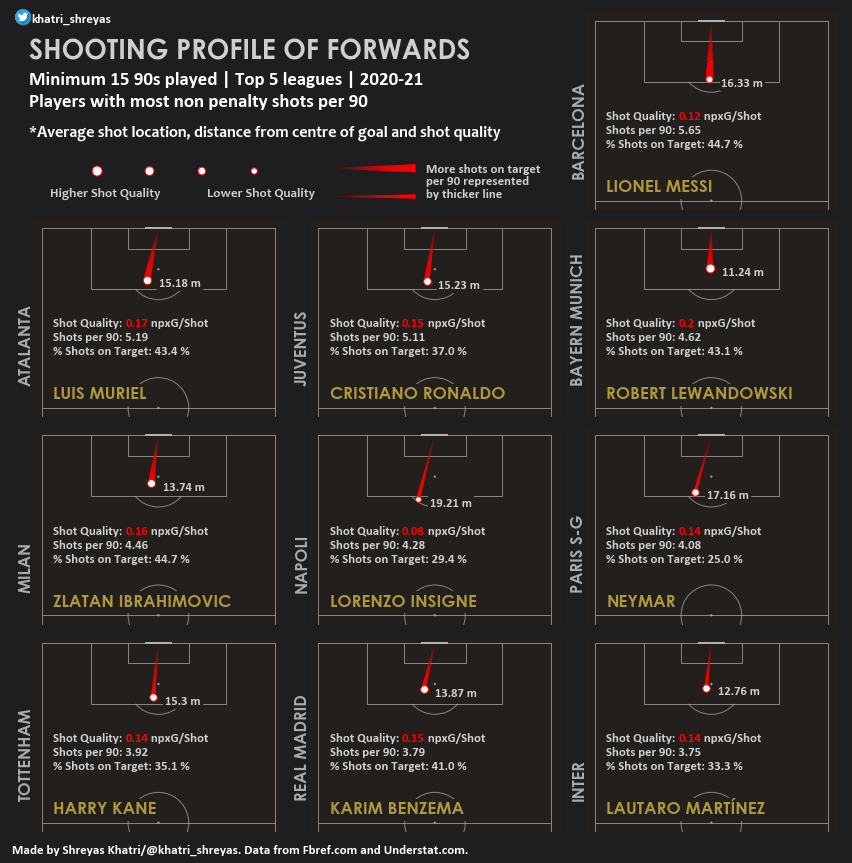

In [13]:
fig, ax = plt.subplots(figsize=(12,12))
fig.set_facecolor(background)
ax.axis('off')

ax = fig.add_axes([0.68,0.76,0.30,0.23])
shotmap(0,ax)

ax = fig.add_axes([0.04,0.52,0.30,0.23])
shotmap(2,ax)

ax = fig.add_axes([0.36,0.52,0.30,0.23])
shotmap(1,ax)

ax = fig.add_axes([0.68,0.52,0.30,0.23])
shotmap(3,ax)

ax = fig.add_axes([0.04,0.28,0.30,0.23])
shotmap(4,ax)

ax = fig.add_axes([0.36,0.28,0.30,0.23])
shotmap(5,ax)

ax = fig.add_axes([0.68,0.28,0.30,0.23])
shotmap(6,ax)

ax = fig.add_axes([0.04,0.04,0.30,0.23])
shotmap(7,ax)

ax = fig.add_axes([0.36,0.04,0.30,0.23])
shotmap(9,ax)

ax = fig.add_axes([0.68,0.04,0.30,0.23])
shotmap(8,ax)

plt.tight_layout()

#LABELS AND TITLES
fig.text(0.04,0.935,'SHOOTING PROFILE OF FORWARDS', size=27, family='Century Gothic', color=in_col, weight='heavy')
fig.text(0.04,0.905,'Minimum 15 90s played | Top 5 leagues | 2020-21', size=19)
fig.text(0.04,0.88,'Players with most non penalty shots per 90', size=19)
fig.text(0.04,0.845,'*Average shot location, distance from centre of goal and shot quality', size=16, family='Candara')
fig.text(0.02,0.015,'Made by Shreyas Khatri/@khatri_shreyas. Data from Fbref.com and Understat.com.', 
         size=13, weight='heavy')

# LEGENDS
ax = fig.add_axes([0.11,0.73,0.2,0.09])
ax.axis('off')
ax.set_ylim(0.45,0.75)
ax.scatter(np.array([0.2,0.4,0.6,0.8]),np.array([0.7]*4), s=np.array([100,80,60,40]), c='white', edgecolor=shot_col)
ax.text(0.02,0.6,'Higher Shot Quality', family='Candara', c=in_col, size=13)
ax.text(0.62,0.6,'Lower Shot Quality', family='Candara', c=in_col, size=13)
#WITH PITCH
ax = fig.add_axes([0.34,0.755,0.2,0.09])
pitch = mplsoccer.VerticalPitch(pitch_type='opta',pitch_color=background,
                            linewidth=1, line_alpha=0, half=True, goal_alpha=0)
pitch.draw(ax=ax)
pitch.lines(80, 95, 80, 5, lw = 8,
            transparent=True, comet=True, color=shot_col, ax=ax,zorder=1)
pitch.lines(60, 95, 60, 5, lw = 4,
            transparent=True, comet=True, color=shot_col, ax=ax,zorder=1)
ax.text(-6, 59,'More shots on target\nper 90 represented\nby thicker line', size=13, c=in_col)

# TWITTER
ax2 = fig.add_axes([0.02,0.97,0.025,0.025])
ax2.axis('off')
img = plt.imread('..//..//Comparison/Player_Club_Images\\twitter.png')
ax2.imshow(img)
fig.text(0.043,0.9775,'khatri_shreyas', size=13, weight='bold')

#plt.savefig('Images/ShotProfile', facecolor=background, dpi=300)